# Evaluation script
* needs to be executed only once
* only after all experiments are done
* again only works with W&B and needs manual adjustments of the sweep ID's
* if there are more than 'fixed_sample_size' experiments, it just takes the 3 latest ones (no quality selection)
* using a private endpoint to get model performance on test set (everytime 'get_models' is called with the already selected models)
* with 'get_data' the predictions and performance  can be drawn from the training/validation patch

In [1]:
import numpy as np
import wandb
from matplotlib import pyplot as plt

from evaluation_utils import *

In [2]:
wandb_run = wandb.init(project="htcv", entity="nicojahn")

api = wandb.Api()
# Project is specified by <entity/project-name>
runs = api.runs("nicojahn/htcv")

wandb: Currently logged in as: nicojahn (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.33 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [3]:
validation_sample_size = 495444
classifier_size = 140

final_data = {}
fixed_lambda = 0.1
fixed_nb_pru = 5
fixed_models = "h30"
fixed_sample_size = 3

replacement = {"h30":60, "rgb":70, "hsi":70, "s10000":80, "t10":80}
# precentage of pruned members from the subset of classifiers
#percentage = lambda x: x/(replacement[fixed_models]/100)
# precentage of pruned members from the whole set
percentage = lambda x: x/(classifier_size/100)

parameter_study_sweeps = ["e3n4o1qa", "94l7tbvl", "e2k8xlfk",]
runtime_multiworker_sweeps = ["u4ivjmwe",]
runtime_dataset_size_sweeps = ["4z8epoao",]
prune_5_oo_10_sweeps = ["mspenh20",]

# parameter studies

In [4]:
# relevant W&B experiments for parameter studies
parameter = get_data(parameter_study_sweeps, runs)

In [5]:
parameter_nb_pru = parameter[(parameter["models"]==fixed_models) & (parameter["lambda"]==fixed_lambda)] \
                    .groupby("nb_pru").head(fixed_sample_size)
# validation performance
print_latex_friendy(parameter_nb_pru.groupby("nb_pru")
                    .agg({'accuracy':['mean','std'], 'time':['mean','std'], 'name':'size'}))

nb_pru &     accuracy &            time \tn
     1 & 32.1 $\pm$ 12.2 &      0.3 $\pm$ 0.1 \tn
     3 &  45.9 $\pm$ 7.2 &   582.4 $\pm$ 87.1 \tn
     5 &  54.1 $\pm$ 2.1 & 1851.5 $\pm$ 293.1 \tn
     7 &  56.4 $\pm$ 0.7 &  3480.9 $\pm$ 22.3 \tn


In [6]:
# test performance
tmp = get_models(parameter_nb_pru, wandb_run).sort_values("nb_pru")
print_latex_friendy(tmp.rename(columns={"test_accuracy":"accuracy"})[["nb_pru","accuracy","time"]]
                    .groupby("nb_pru").agg({'accuracy':['mean','std'], 'time':['mean','std']}))

nb_pru &    accuracy &            time \tn
     1 & 25.5 $\pm$ 7.6 &      0.3 $\pm$ 0.1 \tn
     3 & 30.3 $\pm$ 4.5 &   582.4 $\pm$ 87.1 \tn
     5 & 37.2 $\pm$ 0.1 & 1851.5 $\pm$ 293.1 \tn
     7 & 39.0 $\pm$ 0.2 &  3480.9 $\pm$ 22.3 \tn


In [7]:
final_data["result_set_size"] = get_results_formatted(tmp, "percentage", "remaining", percentage)

In [8]:
parameter_lambda = parameter[(parameter["models"]==fixed_models) & (parameter["nb_pru"]==fixed_nb_pru)] \
                    .groupby("lambda").head(fixed_sample_size)
# validation performance
print_latex_friendy(parameter_lambda[["lambda","accuracy","name"]].groupby("lambda")
                    .agg({'accuracy':['mean','std'], 'name':'size'}))

lambda &    accuracy \tn
   0.0 & 52.1 $\pm$ 1.3 \tn
   0.1 & 54.1 $\pm$ 2.1 \tn
   0.3 & 54.1 $\pm$ 1.7 \tn
   0.5 & 53.2 $\pm$ 1.0 \tn
   0.7 & 42.6 $\pm$ 0.4 \tn
   0.9 & 16.3 $\pm$ 3.5 \tn
   1.0 & 17.1 $\pm$ 2.0 \tn


In [9]:
# test performance
tmp = get_models(parameter_lambda, wandb_run).sort_values("lambda")
print_latex_friendy(tmp.rename(columns={"test_accuracy":"accuracy"})[["lambda","accuracy"]]
                    .groupby("lambda").agg({'accuracy':['mean','std']}))

lambda &    accuracy \tn
   0.0 & 36.5 $\pm$ 3.4 \tn
   0.1 & 37.2 $\pm$ 0.1 \tn
   0.3 & 36.7 $\pm$ 0.4 \tn
   0.5 & 35.0 $\pm$ 0.3 \tn
   0.7 & 26.9 $\pm$ 1.7 \tn
   0.9 & 15.2 $\pm$ 0.2 \tn
   1.0 & 17.0 $\pm$ 1.5 \tn


In [10]:
parameter_models = parameter[(parameter["lambda"]==fixed_lambda) & (parameter["nb_pru"]==fixed_nb_pru)] \
                    .replace({"models": replacement}).groupby("models").head(fixed_sample_size)
# validation performance
print_latex_friendy(parameter_models[["models","time","name"]].groupby("models")
                    .agg({'time':['mean','std'], 'name':'size'}))

models &            time \tn
    60 & 1851.5 $\pm$ 293.1 \tn
    70 & 2177.3 $\pm$ 296.3 \tn
    80 &  2345.2 $\pm$ 47.6 \tn


In [11]:
# test performance
tmp = get_models(parameter_models, wandb_run).sort_values("models")
print_latex_friendy(tmp.rename(columns={"test_accuracy":"accuracy"})[["models","time"]]
                    .groupby("models").agg({'time':['mean','std']}))

models &            time \tn
    60 & 1851.5 $\pm$ 293.1 \tn
    70 & 2177.3 $\pm$ 296.3 \tn
    80 &  2345.2 $\pm$ 47.6 \tn


# runtime performance

In [12]:
# relevant W&B experiment for runtime performance (number of workers)
performance = get_data(runtime_multiworker_sweeps, runs)

In [13]:
performance_m = performance[(performance["lambda"]==fixed_lambda) & (performance["nb_pru"]==fixed_nb_pru) & \
                            (performance["models"]==fixed_models)] \
                    .groupby("m").head(fixed_sample_size)
# validation performance
print_latex_friendy(performance_m.groupby("m")
                    .agg({'accuracy':['mean','std'], 'time':['mean','std'], 'name':'size'}))

m &    accuracy &            time \tn
1 & 52.0 $\pm$ 1.9 & 1829.1 $\pm$ 236.3 \tn
2 & 54.7 $\pm$ 0.9 & 1110.6 $\pm$ 157.1 \tn
4 & 54.0 $\pm$ 0.9 & 1125.6 $\pm$ 129.0 \tn
6 & 54.4 $\pm$ 0.4 & 1213.5 $\pm$ 217.7 \tn
8 & 54.3 $\pm$ 0.7 & 1700.8 $\pm$ 288.3 \tn


In [14]:
# test performance
tmp = get_models(performance_m, wandb_run).sort_values("m")
print_latex_friendy(tmp.rename(columns={"test_accuracy":"accuracy"})[["m","time"]]
                    .groupby("m").agg({'time':['mean','std']}))

m &            time \tn
1 & 1829.1 $\pm$ 236.3 \tn
2 & 1110.6 $\pm$ 157.1 \tn
4 & 1125.6 $\pm$ 129.0 \tn
6 & 1213.5 $\pm$ 217.7 \tn
8 & 1700.8 $\pm$ 288.3 \tn


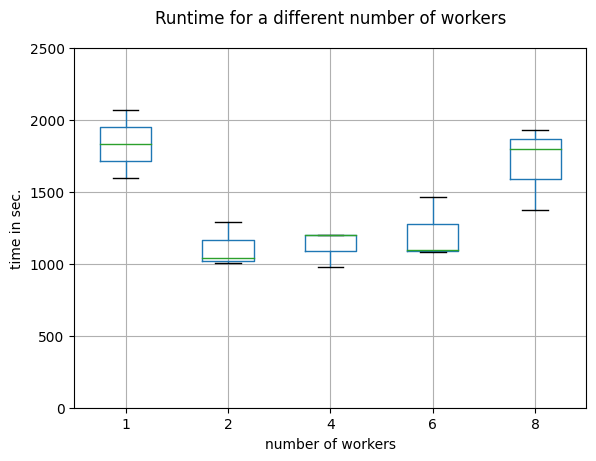

In [15]:
from matplotlib import pyplot as plt
performance_m.boxplot(by="m",column=["time"])
plt.suptitle("Runtime for a different number of workers")
plt.title("")
plt.xlabel("number of workers")
plt.ylabel("time in sec.")
plt.ylim([0,2500])
plt.show()

In [16]:
# relevant W&B experiment for runtime performance (data set size)
dataset = get_data(runtime_dataset_size_sweeps, runs)

In [17]:
dataset_size = dataset[(dataset["lambda"]==fixed_lambda) & (dataset["nb_pru"]==fixed_nb_pru) & \
                       (dataset["models"]==fixed_models)] \
            .groupby("data_set_size").head(fixed_sample_size)
# validation performance
print_latex_friendy(dataset_size.groupby("data_set_size")
                    .agg({'time':['mean','std'], 'name':'size'}))

data_set_size &            time \tn
          100 &  1808.1 $\pm$ 14.1 \tn
         1000 & 1675.7 $\pm$ 144.3 \tn
        10000 & 1904.6 $\pm$ 124.7 \tn
        50000 & 2229.9 $\pm$ 217.1 \tn
       100000 & 2580.4 $\pm$ 194.2 \tn
       250000 & 4038.6 $\pm$ 280.6 \tn
       495444 &  5611.1 $\pm$ 47.8 \tn


In [18]:
# test performance
tmp = get_models(dataset_size, wandb_run).sort_values("data_set_size")
print_latex_friendy(tmp.rename(columns={"test_accuracy":"accuracy"})[["data_set_size","accuracy","time"]]
                    .groupby("data_set_size").agg({'accuracy':['mean','std'],'time':['mean','std']}))

data_set_size &    accuracy &            time \tn
          100 & 34.1 $\pm$ 1.2 &  1808.1 $\pm$ 14.1 \tn
         1000 & 37.9 $\pm$ 1.9 & 1675.7 $\pm$ 144.3 \tn
        10000 & 36.0 $\pm$ 1.0 & 1904.6 $\pm$ 124.7 \tn
        50000 & 39.6 $\pm$ 0.3 & 2229.9 $\pm$ 217.1 \tn
       100000 & 38.4 $\pm$ 2.2 & 2580.4 $\pm$ 194.2 \tn
       250000 & 37.9 $\pm$ 0.8 & 4038.6 $\pm$ 280.6 \tn
       495444 & 36.3 $\pm$ 1.2 &  5611.1 $\pm$ 47.8 \tn


In [19]:
data = tmp.rename(columns={"test_accuracy":"accuracy"})[["data_set_size","accuracy","time"]] \
                    .groupby("data_set_size").agg({'accuracy':['mean','std'],'time':['mean','std']})

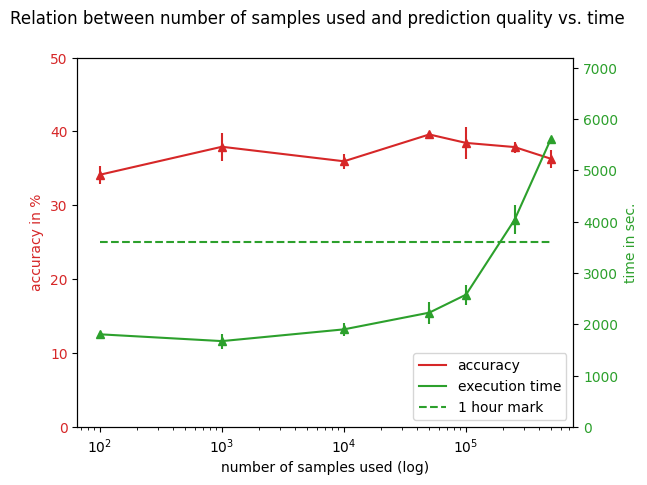

In [20]:
fig, ax1 = plt.subplots() 

mean, std = data["accuracy"].to_numpy().T*100
color = 'tab:red'
ax1.errorbar(data.index, mean, std, linestyle='None', marker='^', color=color)
ax1.plot(data.index, mean, color=color, label='accuracy')
ax1.set_ylim([0,50])
ax1.set_ylabel('accuracy in %', color = color) 
ax1.tick_params(axis ='y', labelcolor = color) 

# taken from: https://stackoverflow.com/a/26339101
handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)

ax2 = ax1.twinx()
mean, std = data["time"].to_numpy().T
color = 'tab:green'
ax2.errorbar(data.index, mean, std, linestyle='None', marker='^', color=color)
ax2.plot(data.index, mean, color=color, label='execution time')
ax2.plot(data.index, np.ones_like(data.index)*(60*60), '--', color=color, label='1 hour mark')
ax2.set_ylim([0,(60*60*2)])
ax2.set_ylabel('time in sec.', color = color)
ax2.tick_params(axis ='y', labelcolor = color)

# taken from: https://stackoverflow.com/a/26339101
handles, labels = plt.gca().get_legend_handles_labels()
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)

ax1.set_xlabel('number of samples used (log)')
plt.suptitle("Relation between number of samples used and prediction quality vs. time")
plt.title("")
plt.xscale('log')

plt.legend(newHandles, newLabels, loc='lower right')
plt.show()

In [21]:
final_data["pruning_data_size"] = get_results_formatted(tmp, "size", "data_set_size", \
                                    lambda x: replace_feature_number(x,validation_sample_size))

# 5 out of 10

In [22]:
# relevant W&B experiment for pruning 5 out of the 10 best models
subset = get_data(prune_5_oo_10_sweeps, runs)

In [23]:
subset_lambda = subset[(subset["lambda"]==fixed_lambda) & (subset["nb_pru"]==fixed_nb_pru)] \
                    .groupby("lambda").head(fixed_sample_size)
# validation performance
print_latex_friendy(subset_lambda.groupby("lambda")
                    .agg({'accuracy':['mean','std'], 'time':['mean','std']}))

lambda &    accuracy &         time \tn
   0.1 & 52.4 $\pm$ 0.2 & 230.6 $\pm$ 8.4 \tn


In [24]:
# test performance
tmp = get_models(subset_lambda, wandb_run).sort_values("lambda")
print_latex_friendy(tmp.rename(columns={"test_accuracy":"accuracy"})[["lambda","accuracy","time"]]
                    .groupby("lambda").agg({'accuracy':['mean','std'], 'time':['mean','std']}))

lambda &    accuracy &         time \tn
   0.1 & 44.3 $\pm$ 0.6 & 230.6 $\pm$ 8.4 \tn


In [25]:
final_data["initial_ensemble_size"] = get_results_formatted(tmp.agg({"nb_pru":forward, \
                                             "time":forward, "test_accuracy":forward,
                                             "data_set_size":forward, "models":num_elem_from_repr}) \
                                         , "top", "models")

# Output of all experiments
* Each model chosen for each experiment (with quality, time and ensemble size)

In [26]:
import json
with open("experiment_output.json", "w") as outfile:
    json_object = json.dumps(final_data, indent = 4)
    outfile.write(json_object)